<font size="7"> <center>NumPy, Monte Carlo and Markov Decision Processes</center>
<font size="5"> <center>Luka Šimek</center> </font>

<font size='5'><b> Imports and Configuration </b></font>

In [35]:
import numpy as np
from scipy.stats import multinomial
from scipy.special import comb
import seaborn as sns
import functools as ft
import itertools as it
from random import randint 
import jdc  # dynamically add to classes

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# set styles depending on Jupyter theme
# sns.set_style('dark')
# plt.style.use('dark_background')
sns.set_style('white')
plt.style.use('ggplot')

In [ ]:
plt.style.available  # run to see mpl styles

# Introduction
<a id='section-introduction'></a>
This 'essay with code' aims to be an improvement on my earlier essay (see [ [1] ](#bib-first)) on Monte Carlo methods and Python, with emphasis of yahtzee-like dice throws and strategies (policies) concerning those. While it introduced some ideas and was indeed functional, it was not 'NumPy friendly' and therefore missed out on a great deal of efficiency. Remedying that will be one of our goals in this notebook. Later, we will also model some more sophisticated frameworks like Markov Chains and Markov Decision Processes, putting this topic in the context of existing mathematical theory. To begin with, let us make a point about NumPy's efficiency by simply calculating the number of 'perfect rolls' of five dice, i.e. those that are yahtzees.

In [6]:
%%time
# naive version
_5_same = lambda L: L[:-1] == L[1:]
sum([_5_same( [randint(1, 6) for _ in range(5)] ) for __ in range(100_000)])/100_000

CPU times: user 228 ms, sys: 0 ns, total: 228 ms
Wall time: 227 ms


0.0007

In [7]:
%%time
# naive with numpy's rng
_5_same = lambda arr: np.all(arr[:-1] == arr[1:])
sum(_5_same(np.random.randint(1, 7, 5)) for _ in range(100_000))/100_000

CPU times: user 744 ms, sys: 145 ms, total: 889 ms
Wall time: 736 ms


0.00075

In [8]:
%%time
# numpy done wrong
np.apply_along_axis(lambda row: np.all(row[:-1] == row[1:]), axis=1, arr=np.random.randint(1, 7, (100_000, 5))).mean()

CPU times: user 305 ms, sys: 507 µs, total: 306 ms
Wall time: 306 ms


0.00074

In [9]:
%%time
# numpy done right
matrix = np.random.randint(1, 7, (100_000, 5))
np.all(matrix[:, :-1] == matrix[:, 1:], axis=1).mean()

CPU times: user 5.42 ms, sys: 643 µs, total: 6.06 ms
Wall time: 5.47 ms


0.00067

# The `Dice` Class
<a id='section-dice'></a>
<a id='subsection-generation'></a>
## Generation
The result of rolling 5 dice can be represented in two ways:
- an array-like object of 5 elements, where the $j$-th is the number that fell on die $j$
- an array-like object of 6 elements, where the $j$-th is the number of dice that fell $j$

Though both have their advantages, the latter proves to be better for our needs overall and also does not contain any useless information (we do not care about the order of the dice). We will call that structure an *arrangment* (*of dice*). Moreover, we can generalize, considering $k$ dice with $s$ faces in $n$ simulations. Additionaly, we can consider the possiblity of loaded dice, having the probability vector $p$ as a fourth parameter.

In [10]:
class Dice(np.ndarray):
    rng = np.random.default_rng()
    def __new__ (cls, n=10_000, s=6, k=5, p=None, dtype=np.uint8):
        # requires either p or s
        if p is None:
            p = np.ones(s)/s
        else:
            s = np.size(p)
        
        arr = cls.rng.multinomial(k, p, n).astype(dtype).view(cls)
        arr.n = n
        arr.s = s
        arr.k = k
        arr.p = p
        return arr

    
    def __array_finalize__(self, arr):
        if arr is not None:
            self.n = getattr(arr, 'n', None)
            self.s = getattr(arr, 's', None)
            self.k = getattr(arr, 'k', None)
            self.p = getattr(arr, 'p', None)

In [11]:
Dice(n=5, k=10, p=np.array([0.2, 0.1, 0.1, 0.1, 0.5]))

Dice([[3, 3, 1, 1, 2],
      [3, 1, 0, 0, 6],
      [2, 1, 1, 1, 5],
      [2, 0, 3, 0, 5],
      [3, 2, 0, 0, 5]], dtype=uint8)

Adding `n` and `s` as attributes was not strictly necessary, but they will provide a more user friendly frontend to the class.

## A Method for re-rolling
<a id='subsection-rerolling'></a>
It is important that we have a method that can simulate the re-rolling of some of the dice. More concretely, to an arrangement we will map a *sub-arrangement* which will represent those dice we wish to roll again. For elegance we will implement it as the operator `//`.

In [13]:
%%add_to Dice
def __floordiv__(self, other):
    return self - other + self.rng.multinomial(other.sum(axis=1).astype(np.int64), self.p)
def __ifloordiv__(self, other):
    self = self - other + self.rng.multinomial(other.sum(axis=1).astype(np.int64), self.p)
    return self

## The Strategy and Reward Functions 
<a id='subsection-functions'></a>
There are two kinds of functions that are important to our simulation:
- the *strategy*, *policy* or *decision* function. This function tells us which dice to re-roll based on their current arrangement. For example, if we wish to have a yahtzee in three rolls, we should always keep those dice which we have the most of at the moment. We represent these functions with an arrangement to its subarrangement mapping.
- the *score* or *reward* function. For example, such a function may return $0$ or $1$ based on whether we rolled a yahtzee. A bit more complicated one may return $5k+50$ for a yahtzee of $k$'s. We represent it by a mapping of arrangement to number (real or integer).

We will now define a couple of policies. First, a simple function that keeps dice with those numbers that are most common.

In [16]:
def pol_keepmax(arr):
    subarr = arr.copy()
    subarr[np.arange(arr.n), subarr.argmax(axis=1)] = 0
    return subarr

Now, a more complicated function. We are aiming for a generalized straight (all $k$ dice consecutive; note that this makes sense for $k \leq s$ only). Our process is as follows: first we reduce numbers to $1$ or keep them as $0$ since we dont need multiple appearances of any number. Then we will calculate the trailing sums of length $k$. Where we find the maximum is where we should keep dice.

In [17]:
def pol_genstraight(arr):
    if (arr.k > arr.s):
        raise ValueError(f'The number of dice must be at most the number of faces. Passed were {k=} and {s=}.')

    subarr = arr > 0
    cum_sum = subarr.cumsum(axis=1)
    k_sum = cum_sum - np.hstack((np.zeros((arr.n, arr.k)), cum_sum))[:, :-arr.k] 
    heads = k_sum.argmax(axis=1)[:, None]

    col_indices = np.tile(np.arange(arr.s), arr.n).reshape(arr.n, arr.s)
    mask = (col_indices > heads) | (heads - col_indices >= arr.k)
    subarr[mask] = 0

    return arr - subarr

Let us tie functions such as these to our method for rolling. Note that further parallelization is not possible, as each new decision depends on the outcome of a roll that precedes it. The method will take a tuple of decision functions, since we may wish to change the policy over time.

In [19]:
%%add_to Dice
def roll(self, *pols, rerolls=2):
    # note: self is a local variable
    pol_cycle = it.cycle(pols)
    for _ in range(rerolls):
        self //= next(pol_cycle)(self)
    return self

In [20]:
%%time
x = Dice(n=1_000_000); x= x.roll(pol_keepmax); 
m = np.any(x==5, axis=1).view(np.ndarray).mean()
print(f'{m=:.8%}')

m=4.57810000%
CPU times: user 572 ms, sys: 31.2 ms, total: 603 ms
Wall time: 611 ms


It is come to write some reward functions. They will work in tandem with the above decision functions and will return $1$ or $0$ depending if the arragement corresponds to a generalized yahtzee (all dice the same) or straight (all $k$ dice consecutive).

In [21]:
def rf_y01(arr):
    return np.any(arr == arr.k, axis=1)

In [22]:
def rf_s01(arr):
    if (arr.k > arr.s):
        raise ValueError(f'The number of dice must be at most the number of faces. Passed were {k=} and {s=}.')
    
    subarr = np.where(arr > 1, 1, arr)
    cum_sum = subarr.cumsum(axis=1)
    k_sum = cum_sum - np.hstack((np.zeros((arr.n, arr.k)), cum_sum))[:, :-arr.k] 

    return np.any(k_sum == arr.k, axis=1)

Similarly, we provide a function that takes instead a *vector* of reward functions, as many reward functions can be decomposed into sums, and since we may also want to evaluate several reward functions at the same time.

Note that a linear reward function corresponds to a matrix multiplication of the arrangements with a column vector. Multiple reward functions would then correspond to the same, where a single column vector is replaced by stacking multiple. These functions are unlikely to be linear as they often involve some threshold, but may well be linear in some transformation of the arrangements.

In [23]:
%%add_to Dice
def score(self, *rfs):
    return np.hstack([rf(self) for rf in rfs]).view(np.ndarray)

## Some Results
<a id='subsection-dice-results'></a>
Now we can estimate the probability of achieving a yahtzee or straight using the strategies we defined. Note that if $X_1$ is a Bernoulli variable with parameter $p$, then $\frac{X_1+\cdots+X_n}n$ is a binomial variable with mean $p$ and variance $\frac{p(1-p)}n,$ showing the inverse relationship between the variance and the number of iterations. Thus, the variance will quickly drop as $n$ rises, but then continue decreasing ever more slowly. Also, this variance is more noticeable for smaller $p$, making it difficult to control the relative error when $p$ is very small.

In [28]:
n = 1_000_000
%time results = Dice(n).roll(pol_keepmax).score(rf_y01)

CPU times: user 519 ms, sys: 59.2 ms, total: 578 ms
Wall time: 577 ms


In [29]:
true = 0.04602864252569469
mean, sd = results.mean(), np.sqrt(results.var()/n )
mean, sd, abs(mean-true)/sd

(0.045939, 0.00020935283203004441, 0.42818874158733794)

In [30]:
%time results = Dice(n).roll(pol_genstraight).score(rf_s01)

CPU times: user 691 ms, sys: 131 ms, total: 821 ms
Wall time: 821 ms


In [31]:
results.mean()

0.249127

To show how the variance changes with $n$, we will graph the sample variances for simulations of different lengths along with the relative errors.

In [32]:
%%time
ns = np.arange(1_000, 50_001, 50)  #sizes of simulations
results = []  #sample variances
theor = true * (1 - true)/ns  # true variances
relerrs = []  # relative errors
for n in ns:
    result = Dice(n=n).roll(pol_keepmax).score(rf_y01)
    results.append(result.var()/n)
    relerrs.append(abs(result.mean() - true)/true)

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


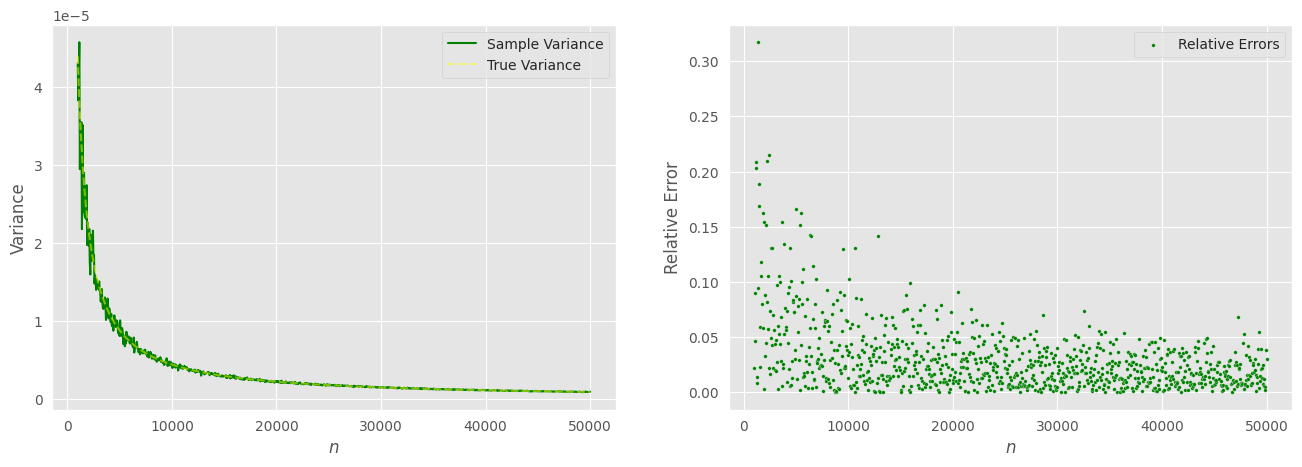

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax1, ax2 = ax

sns.lineplot(x=ns, y=results, color='green', label='Sample Variance', ax=ax1)
sns.lineplot(x=ns, y=theor, linestyle='--', label='True Variance', color='yellow', alpha=0.5, ax=ax1)
ax1.legend()
ax1.set_xlabel(r'$n$')
ax1.set_ylabel('Variance')

sns.scatterplot(x=ns, y=relerrs, label='Relative Errors', s=7, color='green', ax=ax2)
ax2.set_xlabel(r'$n$')
ax2.set_ylabel('Relative Error')

# ax1.grid(True), ax2.grid(True)

plt.show()

We have achieved a class capable of performing Monte Carlo simulations in great generality, both in terms of dice and policy and reward function, with NumPy efficiency without major bottlenecks. That efficiency, of course, holds as long as we are capable of writing vectorized functions, which can be challenging in some cases. Still, the code remains functional even for naive for-loop based functions, and even then can be greatly optimized through use of libraries like Numba or of Cython. That is, in fact, true for all of our code and using such libraries would be a worthwile endeavour for applications that are less demonstrative and more practical. For now, however, let us move on to the next section.

# Markov Chains
<a id='section-markov-chains'></a>
We may notice that our transitions between different arrangements can be interpreted as transitions between states of a Markov chain, since clearly a single transition depends solely on the current state/arrangement. Thus, in such a framework, the states would be all possible dice arrangements, while the transition matrix would be implied by the decision function. As other Markov chains, this one too may or may not be regular (time-homogenous); if our decision function is independent of the ordinal number of the re-roll, then it is regular. This may not be optimal &ndash; consider the example of rolling the dice 15 times aiming to get a high sum. If we are on our last roll it would clearly be wise to keep our 5's. On our first roll, however, we should keep only 6's.

This framework certainly has advantages: it is a common one across different similar problems and it enables both Monte Carlo simulations as well efficient, versatile and repeated theoretical calculations. A disadvantage is that it takes some effort to construct the transition matrix from a decision function, at least efficiently. A greater disadvantage relates to scaling. Note that $k$ $s$-faced dice generate $\binom{k+s-1}{s-1}$ arrangements, a quantity that can increase enourmously even from a modest increase of $k$ or $s$.

## Generating Arrangements
<a id='subsection-generating-arrangements'></a>
The following function will let us generate a table of all arrangements for given $k$ and $s$.

In [37]:
def get_arrs(k=5, s=6, dtype=np.uint8):
    arrs = np.zeros((1,s), dtype=dtype)
    base_arrs = np.eye(s, dtype=dtype)

    for _ in range(k):
        add_arrs = np.tile(base_arrs, (arrs.shape[0], 1))
        arrs = np.repeat(arrs, s, axis=0) + add_arrs
        arrs = np.unique(arrs, axis=0)
        
    return arrs

We also need to calculate the probabilities of different arrangements being rolled. This is important both for the initial distribution of states in the Markov chain, but also for the transition matrix, as we will later see. As was quietly implied earlier, arrangements are in fact realizations of a multinomial random variable (with $k$ trials and $s$ outcomes), so we need the multinomial probability mass function. This function is somewhat complicated and potentially involves very large and small numbers, so we use a vectorized and numerically stable solution from `scipy`.

In [38]:
def get_probs(arrs, p=None):
    k = arrs[0].sum()
    
    if p is None:
        p = np.ones(arrs.shape[1])/arrs.shape[1]
    
    return multinomial.pmf(arrs, n=k, p=p)

## The Transition Matrix
<a id='subsection-transition-matrix'></a>

In [39]:
def get_tm(arrs, pol, p=None):
    if p is None:
        p = np.ones(arrs.shape[1])/arrs.shape[1]

    subarrs = pol(arrs)
    
    return multinomial.pmf(
        (subarrs-arrs)[:, None, :] + arrs,
        n=subarrs.sum(axis=1, keepdims=True),
        p=p
    )

## The `DiceChain` Class
<a id='subsection-dicechain'></a>
We are now ready to construct a Markov chain class.

In [40]:
class DiceChain:
    def __init__(self, *pols, k=5, s=6, p=None, dtype=np.uint8):
        if p is None:
            p = np.ones(s)/s
        
        self.states = get_arrs(k, s, dtype)
        self.init_probs = get_probs(self.states, p)
        self.trans_mats = tuple(get_tm(self.states, pol, p) for pol in pols)


    def _roll_reg(self, mat, probs, rerolls):
        return probs @ np.linalg.matrix_power(mat, rerolls)

    def _roll_irr(self, *mats, probs, rerolls):
        mat_cycle = it.cycle(mats)
        mat = np.eye(self.states.shape[0])
        for _ in range(rerolls):
            mat = mat @ next(mat_cycle)
        return probs @ mat
        

    def roll(self, *mats, probs=None, rerolls=2):
        mats = self.trans_mats if not mats else mats
        probs = self.init_probs if probs is None else probs

        if len(mats) == 1:
            return self._roll_reg(mats[0], probs=probs, rerolls=rerolls)
        else:
            return self._roll_irr(mats, probs=probs, rerolls=rerolls)
            
    
    def random_walk(self, *mats, n=10_000, probs=None, rerolls=2):
        mats = self.trans_mats if not mats else mats
        probs = self.init_probs if probs is None else probs
    
        mat_cycle = it.cycle(mats)

        indices = np.random.choice(self.states.size, n, probs, replace=True)
        for _ in range(rerolls):
            indices = (next(mat_cycle).cumsum(axis=1) > np.random.uniform(self.states.size)[:, None]).argmax(axis=1)

        return np.bincount(indices)/self.states.size

   
    def score(self, *rfs, probs=None):
        probs = self.init_probs if probs is None else probs
        return np.vstack([rf(self.states)*probs for rf in rfs])

Now we can also do some theoretical calculations of probabilities. We will compare the probabilities of getting (at least) 5, 4, and 3 of a kind as the number of re-rolls increases.

In [42]:
def pol_keepmax_mc(arr):
    subarr = arr[:, ::-1].copy()  # we reverse to keep larger numbers in case of ties
    subarr[np.arange(arr.shape[0]), subarr.argmax(axis=1)] = 0
    return subarr[:, ::-1]
keepmax_mat = get_tm(get_arrs(), pol_keepmax_mc)
rf_y01 = lambda arrs: np.any(arrs==5, axis=1) 
rf_p01 = lambda arrs: np.any(arrs==4, axis=1)
rf_t01 = lambda arrs: np.any(arrs==3, axis=1)

In [43]:
chain = DiceChain(pol_keepmax_mc, k=5, s=6)
probs = chain.init_probs
y = np.array([[0], [0], [0]])

for reroll in range(30):
    y = np.hstack((y, chain.score(rf_y01, rf_p01, rf_t01, probs=probs).sum(axis=1, keepdims=True)))
    
    probs = chain.roll(probs=probs, rerolls=1)

y=y[:, 1:]

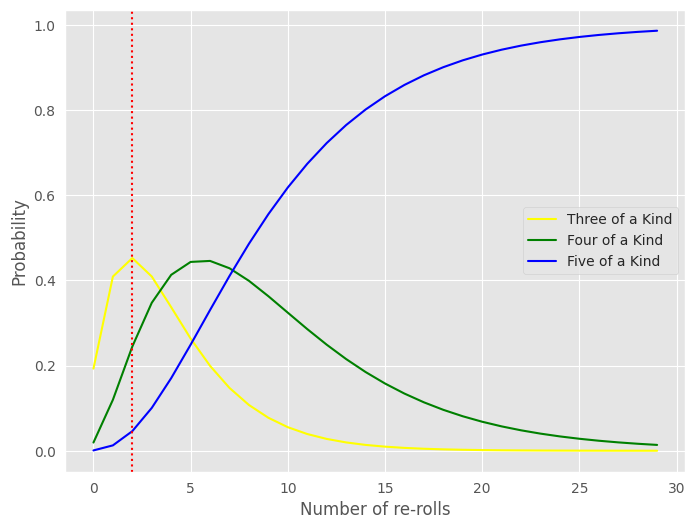

In [50]:
ns = np.arange(30)
fig, ax = plt.subplots(figsize=(8, 6))

for ys, label, color in zip(
    y[::-1], ['Three of a Kind', 'Four of a Kind', 'Five of a Kind'], ['yellow', 'green', 'blue']
):
    sns.lineplot(x=ns, y=ys, color=color, label=label, ax=ax)

ax.axvline(x=2, color='red', linestyle=':')
ax.set_xlabel('Number of re-rolls')
ax.set_ylabel('Probability')
plt.show()

## Example: Poison Die
<a id='subsection-example-poison-die'></a>
We could also consider something different and more interesting. Suppose we have 5 7-faced dice, where the 7th face is *poisonous*, meaning that it cannot be re-rolled and it always brings the score down to zero. Otherwise, the reward is equal to the square root of the product of the numbers rolled. Of course, this 7th face will have some smaller probability $p_7$ of being rolled. While it is simple to calculate the expected reward (or loss) for a given roll, what makes this interesting is that potential rewards increase if we succeed in increasing the numbers in a given re-roll, meaning that greedy strategies are unlikely to be optimal. For now, we will define a parametrized family of strategies:
$$f_t: \ \text{re-roll those numbers smaller than}\ t$$
We will continue with this topic in the next section.

In [110]:
def pol_poison_t(arrs, t):
    indices = np.tile(np.arange(7), (arrs.shape[0], 1)) + 1
    return arrs * ((indices < t) & (indices != 7))

In [111]:
def rf_poison(arrs):
    indices = np.tile(np.arange(7), (arrs.shape[0], 1)) + 1
    return np.sqrt((indices**arrs).prod(axis=1) * (arrs[:, 6] == 0))

<a id='section-mdp'></a>
# Markov Decision Processes
<a id='subsection-backward-induction'></a>
## Backward Induction
In previous sections we successfully tested a number of strategies, but cannot in more complicated examples gurantee that such functions are indeed optimal in the sense that utilising them maximizes the expected value of the reward function. It is then natural to ask whether we can indeed find such an optimum in a reasonable amount of time. At first glance the task seems daunting. In our default case, each arrangement has between $k+1=6$ and $2^k=32$ subarrangements, putting the number of strategies between the extremely high $6^{252}$ and $32^{252}$. Clearly, evaluating all candidates is impossible. Additionaly, in a scenario involving multiple re-rolls we need to optimize for several such strategies and their pairings. However, we will show that evaluating all possibilities is not necessary.

Consider the case in which we must perform a single re-roll. As always, a strategy consists of pairs of arrangements and their subarrangements of dice to be re-rolled. The key fact is that we can choose these subarrangements separately for each of the arrangements, since there is no interaction between our choices. This greatly reduces the needed number of evaluations to between $6\cdot252$ and $32\cdot252$.

Let us assume we have optimized the strategy for our final re-roll. Then we can also optimize the penultimate strategy analogously. Whereas previously we were choosing strategies that lead us to those ending arrangements evaluated highly by the reward function, now we aim for those arrangements where we are likely to yield success after one additional re-roll. In other words, we have adopted a new reward function corresponding to the situation at the last re-roll. We repeat this process inductively for any number of re-rolls. Let us restate this algorithm more clearly:
- Set $k, s$, reward function $R$, number of re-rolls $N$ and $R_N=R$ the $N$-th reward function
- For $n=N, N-1, \ldots 1$:
  - For each $A$ arrangement of $k$ $s$-faced dice:
    - Iterate through all subarrangements of $A$ to find subarrangement $S$ such that the expected value $E$ of reward $R_n$ for new arrangements is greatest
  - Let the $n$-th strategy $f_n$ consist of all pairs $(A, S)$
  - If $n > 1$, let the next reward function $R_{n-1}$ consist of all pairs $(A, E)$
- Return $f_1, \ldots, f_N$

We should note that it is not necessary to maximise the expected value of the reward. There are indeed cases where we may prefer lower-risk strategies with lower expected reward but also lower variance or vice-versa. In a two-player game example, a player who is losing may choose a very risky move if the unlikely success is the only way to victory. We can accomodate that by calculating a different $E$ in the above algorithm.

As for the implementation of the above idea, we wish to perform it in a vectorized manner. To do that, we construct transition matrices like in the function `get_tm`, for each possible *constant* strategy, i.e. each strategy which always assigns the same subarrangement. Such functions may not always be possible to implement (when the subarrangement is not in fact part of the arrangement), but this will not be a problem with the probability mass function assigning all zero probabilities in such cases. In this three-dimensional tensor we may then evaluate the reward function along the first axis and choose the maxima. We can repeat the process for updated reward functions.

In [53]:
def get_subarrs(k=5, s=6, dtype=np.uint8):
    return np.vstack(
        [get_arrs(sum_, s) for sum_ in range(k+1)]
    )

In [54]:
def get_tensor(k=5, s=6, subarrs=None, p=None, dtype=np.uint8):
    if p is None:
        p = np.ones(s)/s

    arrs = get_arrs(k, s, dtype)

    if subarrs is None:
        subarrs = get_subarrs(k, s, dtype)

    return multinomial.pmf(
        ((subarrs[:, None, :] - arrs)[:, None, :, :] + arrs[:, None, :]).transpose((0, 2, 1, 3)),
        n=subarrs.sum(axis=1).reshape(subarrs.shape[0], 1, 1),
        p=p
    )

This approach is very memory-intensive even in our default case. Instead of the maximal $2^k=32$ subarrangements for each arrangements, we investigate all subarrangements that exist, of which there are (Chu Shih-Chieh):
$$\sum\limits_{j=s-1}^{k+s-1}\binom j{s-1}=\binom{k+s}s,$$
or $462$ in the default case. This means that we at one point work with a tensor of shape 
$$\binom{k+s}s \times \binom{k+s-1}{s-1} \times \binom{k+s-1}{s-1} \times s$$
of integers (where the type `uint8` helps a lot to save memory and time) and the result is a tensor with shape
$$\binom{k+s}s \times \binom{k+s-1}{s-1} \times \binom{k+s-1}{s-1}$$
and dtype `float64`. In the default case, the former will take up 223.84 MiB of RAM, while the latter will take up 167.88 MiB. Clearly this can increase greatly and rapidly with $k$ and $s$, so we should be very careful to consider those cases.

The `get_tensor` function is also the most time-intensive so far. However, this tensor depends only on $k$, $s$ and the probability vector $p$, meaning it only needs to be computed once for any such setup, after which it may be reused with various reward functions.

In [55]:
def solve(states, tensor, rf, rerolls=2):
    pols = []
    rewards = rf(states)
    
    for _ in range(rerolls):
        tensor_eval = (tensor * rewards).sum(axis=2)
        
        max_indices = tensor_eval.argmax(axis=0)
        pols.append(max_indices)
        rewards = tensor_eval[max_indices, np.arange(tensor_eval.shape[1])]

    return pols[::-1]

## Example: More Complicated Scoring
<a id='subsection-more-complicated-scoring'></a>
We are now ready to compute some optimal policies. Note that the `solve` function returns not functions, but the right indices in the `subarrs` argument. Customizations are of course possible, and we will comment later on these choices. Now we can also find the optimal strategy for a more complicated reward function. This function, for the default case, will reward a straight, full house, poker and yahtzee with greater scores for larger dice.

In [56]:
def rf_sfpy(arrs):
    rewards = np.zeros((arrs.shape[0],))
    
    mask = arrs == 5
    rewards += ((np.argmax(mask, axis=1)+1)*5 + 50) * np.any(mask, axis=1)
                
    mask = arrs == 4
    rewards += ((np.argmax(mask, axis=1)+1)*4 + 40) * np.any(mask, axis=1)
                
    mask3, mask2 = arrs == 3, arrs == 2
    rewards += ((np.argmax(mask3, axis=1)+1)*3+(np.argmax(mask2, axis=1)+1)*2 + 30) * (np.any(mask3, axis=1) & np.any(mask2, axis=1))
                
    mask = arrs < 2
    rewards += 35*(np.all(mask, axis=1) & arrs[:, 0]) + 40*(np.all(mask, axis=1) & arrs[:, 5])

    return rewards

Once we compute the optimal policy, it is not easy to interpret. Therefore, we will just compare it with two simpler alternatives, those being to keep the numers of which we have the most, and to keep the two numbers of which we have the most.

In [57]:
%time tensor = get_tensor()

CPU times: user 6.16 s, sys: 691 ms, total: 6.85 s
Wall time: 6.85 s


In [58]:
rerolls = 5
states = get_arrs()
subarrs = get_subarrs()
funclist = solve(states, tensor, rf_sfpy, rerolls=rerolls)
funclist = [lambda arrs, f=f: subarrs[f] for f in funclist]

In [60]:
pol_keepmax2_mc = lambda arrs: pol_keepmax_mc(pol_keepmax_mc(arrs))
keepmax_mat = get_tm(states, pol_keepmax_mc)
keepmax2_mat = get_tm(states, pol_keepmax2_mc)
matlist = [get_tm(states, f) for f in funclist]

In [61]:
chain = DiceChain()
probs_max1, probs_max2, probs_o = chain.init_probs, chain.init_probs, chain.init_probs
y_max1, y_max2, y_o = [chain.score(rf_sfpy).sum()], [chain.score(rf_sfpy).sum()], [chain.score(rf_sfpy).sum()]

for mat_o in matlist:
    probs_max1 = chain.roll(keepmax_mat, probs=probs_max1, rerolls=1)
    probs_max2 = chain.roll(keepmax2_mat, probs=probs_max2, rerolls=1)
    probs_o = chain.roll(mat_o, probs=probs_o, rerolls=1)
    
    y_max1.append(chain.score(rf_sfpy, probs=probs_max1).sum())
    y_max2.append(chain.score(rf_sfpy, probs=probs_max2).sum())
    y_o.append(chain.score(rf_sfpy, probs=probs_o).sum())

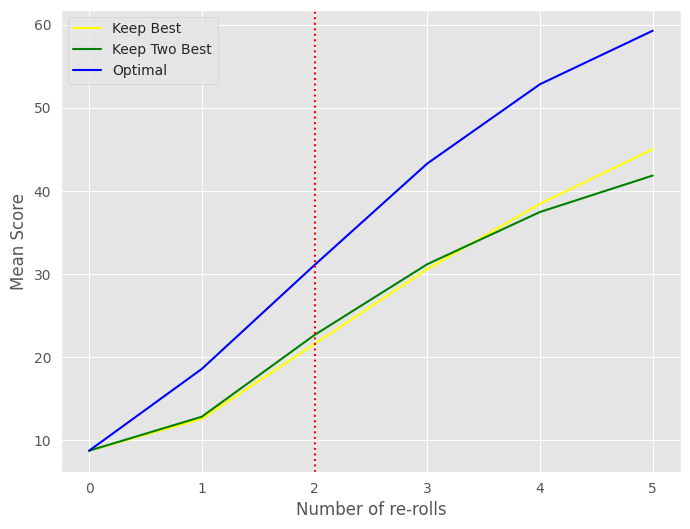

In [67]:
ns = np.arange(rerolls+1)
fig, ax = plt.subplots(figsize=(8, 6))

for ys, label, color in zip(
    [y_max1, y_max2, y_o], ['Keep Best', 'Keep Two Best', 'Optimal'], ['yellow', 'green', 'blue']
):
    sns.lineplot(x=ns, y=ys, color=color, label=label, ax=ax)

if (rerolls > 1):
    ax.axvline(x=2, color='red', linestyle=':')
ax.set_xlabel('Number of re-rolls')
ax.set_ylabel('Mean Score')
plt.xticks(np.arange(min(ns), max(ns) + 1, 1))
plt.show()

## Example: Poison Die Continued
<a id='subsection-poison-die-continued'></a>
In a previous subsection we discussed the poison die game. Here we are able to add the optimal policy. Additionaly, we will assume $p_7=7\%$ and that we have 7 re-rolls. The optimal policy will change depending on those parameters and they can be easily changed in the code below. A thing to note is that we cannot even consider those policies that would re-roll any 7's as this would violate the rules. We will model that by passing only those subarrangements with 0's in the last place to the `subarrs` parameter of `get_tensor`. Another problem may arise here &ndash; since any 'poisoned' arrangements are stuck at score zero, there is no true optimum to choose and this may lead to deformed policies, i.e. those that prescribe impossible moves (re-rolling more of some dice than we have). This will not be a problem here, but otherwise we may wish to intervene manually in the resulting functions.

In [82]:
p_7, rerolls = 0.07, 7
k, s, dtype = 5, 7, np.uint8
p = np.array([(1-p_7)/(s-1)]*(s-1)+[p_7])

states = get_arrs(k, s, dtype)
subarrs = get_subarrs(k, s-1, dtype)
subarrs = np.hstack((subarrs, np.zeros((subarrs.shape[0], 1), dtype)))

In [69]:
%time tensor = get_tensor(k, s, subarrs, p, dtype)

CPU times: user 21.2 s, sys: 3.5 s, total: 24.7 s
Wall time: 25 s


In [70]:
tensor.nbytes/1024**2

752.3432006835938

In [83]:
pols = [ft.partial(pol_poison_t, t=t) for t in range(2, 6+1)]
mats = [get_tm(states, pol, p) for pol in pols]
%time funclist = solve(states, tensor, rf_poison, rerolls)
funclist = [lambda arrs, f=f: subarrs[f] for f in funclist]
matlist = [get_tm(states, f, p) for f in funclist]

CPU times: user 861 ms, sys: 592 ms, total: 1.45 s
Wall time: 1.45 s


In [84]:
chain = DiceChain(k=k, s=s, p=p, dtype=dtype)
probs = [chain.init_probs] * (k+1)  # five f_ts and the optimum
y  = [[chain.score(rf_poison).sum()] for _ in range(1, k+2)]

for mat_o in matlist:
    for idx, mat in enumerate(mats):
        probs[idx] = chain.roll(mat, probs=probs[idx], rerolls=1)
        y[idx].append(chain.score(rf_poison, probs=probs[idx]).sum())
        
    probs[-1] = chain.roll(mat_o, probs=probs[-1], rerolls=1)
    y[-1].append(chain.score(rf_poison, probs=probs[-1]).sum())

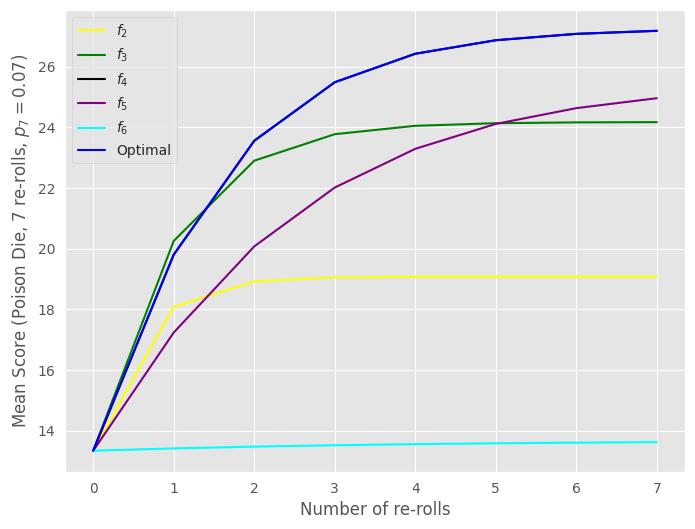

In [96]:
ns = np.arange(rerolls+1)
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['yellow', 'green', 'black', 'purple', 'cyan', 'blue']

for ys, label, color in zip(
    y, [rf'$f_{t}$' for t in range(2, 6+1)] + ['Optimal'], colors
):
    sns.lineplot(x=ns, y=ys, color=color, label=label, ax=ax, alpha=1)

ax.set_xlabel('Number of re-rolls')
ax.set_ylabel(rf'Mean Score (Poison Die, {rerolls} re-rolls, $p_7={p_7:.2f}$)')
plt.xticks(np.arange(min(ns), max(ns) + 1, 1))
plt.show()

Interestingly, the lines of the optimum and $f_4$ seem to overlap, although upon further inspection we will see that there are some very small differences. Still, the optimum and $f_4$ are very 'similar' as mappings. Also, we can note that the optimal policy is optimized for the final score, not the intermediate results, so it is not surprising that is does not dominate at every point in time.

<a id='subsection-about-mdps'></a>
## About MDPs
We could jokingly say that Markov decision processes are exactly what we have been discussing up until now. Intuitively, an MDP is an extension of a Markov chain through a decision maker who aims to select decisions to maximize a certain reward gained throughout the stochastic process. The adjective *Markov* remains as the decision maker does not care about the past; rather only about the current state of the process. Precisely, a Markov Decision Process is a tuple $(S, A, P_a, R_a)$ where
- $S$ is the state space, or set of states,
- $A$ is the action space, for each set describing the set of possible actions,
- $P_a(s, s')$ is the transition probability from state $s$ to $s'$, given that action $a$ was taken and
- $R_a(s, s')$ is the immediate reward after transitioning from state $s$ to $s'$ after taking action $a$.

Added to that may be the policy $\pi \colon S \to A$, a function mapping the action $a$ to given state $s$, as we described in [subsection 2.3.](#subsection-functions)

In analysing an MDP, the goal is indeed to find the optimal (or 'good') policy, meaning one that maximizes the expected value of the cumulative reward. Such optimal policies may indeed be found in MDPs with finite state and action spaces using dynamic programming algorithms that carry substantially the same idea as what we described and implemented in [subsection 4.1.](#subsection-backward-induction) Such algorithms' complexity is polynomial in the size of the space representation. However, the said size can increase expontentially with the dimensions, making such algorithms often unfeasible (see also [Appendix](#appendix)). In such cases, heuristic Monte Carlo tree search algorithms (see [ [4] ](#bib-mcts)) are commonly used and have had great success in training game-playing software. Other approaches are also used &ndash; reinforcement learning is in fact tightly related to MDPs and is commonly used when transition probabilities or rewards are not known (see [ [5] ](#bib-vasseur) for an example with yahtzee). 

Clearly this framework describes our situation quite well, though we can note some differences &ndash; in a typical MDP, rewards are mapped to all action-state pairs, rather than just the final state. Like Markov chains themselves, MDPs usually do not have a time-final state. 

## Conclusion
<a id='subsection-conclusion'></a>
So far we have discussed simpler scnearios consisting of a single roll and several re-rolls, but what about an entire game of yahtzee? Clearly, the optimal policy depends on the state on the board, both for the immediate reward and for long term strategy. Therefore, all states of the board, of which there are very large numbers, should be added to the state space. This is, again, not necessarily a problem. We can imagine an algorithm analogous to the one described in [subsection 4.1.](#subsection-backward-induction) &ndash; we compute the reward function for completed boards and, through backward induction, proceed to compute all reward functions and optimal policies. Still, the set of possible states in four-column yathzee (as described in  [ [1] ](#bib-first)) is prohibitively large, and the *announcement* column complicates gameplay further.

However, in a simpler, single-column version of yahtzee with a simpler scoring scheme (see [ [5] ](#bib-vasseur)), the entire set of states of the board comes at around 1200 billion, making it quite extreme but still not prohibitively expensive. In fact, this was already considered to successfully compute the best policy for that variant of yahtzee, as was documented in [ [6] ](#bib-woodward).

As we briefly mentioned previously, the optimal policy does not have to be equal to the mean score. For example, we may wish to generate new high scores, or in other words, maximize the probability of surpassing a certain score. In those cases, the optimal policy may be one that offer a score distribution with lower mean, but is denser on its right end. Alternatives also arise when we introduce another player. Even though there is no interaction between boards of different players, the true end goal is to obtain a higher score than the opponent. As we noted earlier, a very risky decision may be optimal if the opponent is far ahead. This again greatly increases the state space, leaving the only potentially viable solutions to deep reinforcement learning.

<font size='5'><b> Appendix: How Large is the Tensor? </b></font>
<a id='appendix'></a>

In [subsection 4.1.](#subsection-backward-induction) we commented on the size of the large 3-dimensional tensor (when represented by dtype `float64`). Here we provide a reference for sizes in non-default cases.

In [112]:
def sizef(k, s):
    return comb(k+s, s) * comb(k+s-1, s-1) ** 2 * 8
sizef = np.vectorize(sizef)

In [113]:
def formatter(nbytes):
    units = ['B', 'KiB', 'MiB', 'GiB', 'TiB', 'PiB']
    for idx in range(6):
        if nbytes >= 1024:
            nbytes /= 1024
        else:
            break
    return f'{nbytes:.2f} {units[idx]}'
formatter = np.vectorize(formatter)

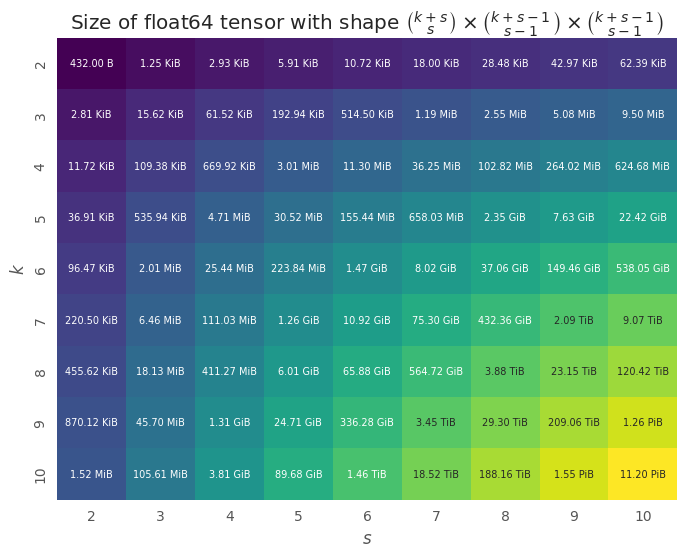

In [114]:
k, s = np.arange(2, 11), np.arange(2, 11)
K, S = np.meshgrid(k, s)
sizes = sizef(K, S)
annot = formatter(sizes)
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    np.log(sizes),
    xticklabels = s,
    yticklabels = k,
    annot = annot,
    annot_kws={'fontsize': 7},
    fmt = '',
    cmap = 'viridis', 
    cbar = False,
    ax=ax
)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$k$')
ax.set_title(r'Size of float64 tensor with shape $\binom{k+s}{s} \times \binom{k+s-1}{s-1} \times \binom{k+s-1}{s-1}$')
plt.show()

<a id='bib'></a>
<font size='5'><b> Bibliography </b></font>
1. [Šimek, L. (2023). *Pseudorandom numbers and Monte Carlo methods* (in Croatian)](#not-implemented). <a id='bib-first'></a>
2. [NumPy Documentation: Subclassing ndarray](https://numpy.org/doc/stable/user/basics.subclassing.html). *Retrieved December 8, 2023.* <a id='bib-subclassing'></a>
3. [Wikipedia: Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process). *Retrieved December 8, 2023.* <a id='bib-mdp'></a>
4. [Wikipedia: Monte Carlo tree search](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search). *Retrieved December 8, 2023.* <a id='bib-mcts'></a>
5. Vasseur, P., & Glenn, J.R. (2019). Using Deep Q-Learning to Compare Strategy Ladders of Yahtzee. <a id='bib-vasseur'></a>
6. Woodward, Phil. (2012). Yahtzee®: The Solution. CHANCE. 16. 18-22. 10.1080/09332480.2003.10554833. <a id='bib-woodward'></a>